# Comparaison de Modèles de Prédiction NDVI

**Objectif :** Entraîner trois modèles différents (SARIMA, XGBoost, LSTM) sur les mêmes données historiques et comparer rigoureusement leurs performances sur une période de test commune (l'année 2024) afin de déterminer le meilleur modèle pour ce problème.

In [1]:
# Installation de tous les paquets nécessaires pour le notebook
!pip install pandas statsmodels xgboost tensorflow scikit-learn matplotlib seaborn

In [2]:
# --- ÉTAPE 0: INSTALLATION DES BIBLIOTHÈQUES ---
!pip install pandas statsmodels xgboost tensorflow scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

import statsmodels.api as sm
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

filterwarnings("ignore")
print("--- DÉBUT DU NOTEBOOK DE COMPARAISON DE MODÈLES ---")

# --- ÉTAPE 1: CHARGEMENT ET PRÉPARATION UNIFIÉE DES DONNÉES ---
print("\n--- ÉTAPE 1: Préparation des données ---")
try:
    df_final = pd.read_csv("data_fusionner_netoyeer.csv")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'data_fusionner_netoyeer.csv' est introuvable.")
    exit()

# Nettoyage robuste
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.interpolate(method='linear', inplace=True)
df_final.bfill(inplace=True)
if 'NDVI_smoothed' in df_final.columns:
    df_final = df_final.drop(columns=['NDVI_smoothed'])
print("✅ Données chargées et nettoyées.")

# Définition de la période de test commune
split_date = '2024-01-01'
test_period_start = pd.to_datetime(split_date)

# Préparation des données pour SARIMA (hebdomadaires)
df_weekly = df_final['NDVI'].resample('W').mean().interpolate().bfill()
train_sarima = df_weekly[df_weekly.index < test_period_start]
test_sarima = df_weekly[df_weekly.index >= test_period_start]

# Préparation des données pour XGBoost et LSTM (journalières avec caractéristiques)
df_model = df_final.copy()
df_model['jour_annee'] = df_model.index.dayofyear
df_model['mois'] = df_model.index.month
for lag in range(1, 8):
    df_model[f'ndvi_lag_{lag}'] = df_model['NDVI'].shift(lag)
df_model = df_model.dropna()
features = [col for col in df_model.columns if col != 'NDVI']
target = 'NDVI'
X = df_model[features]
y = df_model[target]
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]
print("✅ Données préparées pour les 3 modèles.")


--- DÉBUT DU NOTEBOOK DE COMPARAISON DE MODÈLES ---


In [3]:

# --- ÉTAPE 1: CHARGEMENT ET PRÉPARATION UNIFIÉE DES DONNÉES ---
print("\n--- ÉTAPE 1: Préparation des données ---")
try:
    df_final = pd.read_csv("data_fusionner_netoyeer.csv")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'data_fusionner_netoyeer.csv' est introuvable.")
    exit()

# Nettoyage robuste
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.interpolate(method='linear', inplace=True)
df_final.bfill(inplace=True)
if 'NDVI_smoothed' in df_final.columns:
    df_final = df_final.drop(columns=['NDVI_smoothed'])
print("✅ Données chargées et nettoyées.")

# Définition de la période de test commune
split_date = '2024-01-01'
test_period_start = pd.to_datetime(split_date)

# Préparation des données pour SARIMA (hebdomadaires)
df_weekly = df_final['NDVI'].resample('W').mean().interpolate().bfill()
train_sarima = df_weekly[df_weekly.index < test_period_start]
test_sarima = df_weekly[df_weekly.index >= test_period_start]

# Préparation des données pour XGBoost et LSTM (journalières avec caractéristiques)
df_model = df_final.copy()
df_model['jour_annee'] = df_model.index.dayofyear
df_model['mois'] = df_model.index.month
for lag in range(1, 8):
    df_model[f'ndvi_lag_{lag}'] = df_model['NDVI'].shift(lag)
df_model = df_model.dropna()
features = [col for col in df_model.columns if col != 'NDVI']
target = 'NDVI'
X = df_model[features]
y = df_model[target]
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]
print("✅ Données préparées pour les 3 modèles.")



--- ÉTAPE 1: Préparation des données ---
✅ Données chargées et nettoyées.
✅ Données préparées pour les 3 modèles.


In [5]:
# --- ÉTAPE 2: ENTRAÎNEMENT DES TROIS MODÈLES ---
print("\n--- ÉTAPE 2: Entraînement des modèles ---")

# Modèle 1: SARIMA
print("🚀 Entraînement du SARIMA...")
model_sarima = sm.tsa.SARIMAX(train_sarima, order=(0, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)
print("✅ SARIMA entraîné.")

# Modèle 2: XGBoost
print("🚀 Entraînement du XGBoost...")
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
model_xgb.fit(X_train, y_train)
print("✅ XGBoost entraîné.")

# Modèle 3: LSTM
print("🚀 Entraînement du LSTM (cela peut prendre quelques minutes)...")
scaler_X = MinMaxScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler().fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1))
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
model_lstm = Sequential([LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])), Dropout(0.2), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=32, verbose=0)
print("✅ LSTM entraîné.")




--- ÉTAPE 2: Entraînement des modèles ---
🚀 Entraînement du SARIMA...
✅ SARIMA entraîné.
🚀 Entraînement du XGBoost...
✅ XGBoost entraîné.
🚀 Entraînement du LSTM (cela peut prendre quelques minutes)...
✅ LSTM entraîné.


In [6]:

# --- ÉTAPE 3: GÉNÉRATION ET ALIGNEMENT DES PRÉDICTIONS ---
print("\n--- ÉTAPE 3: Génération des prédictions sur la période de test (2024) ---")
pred_sarima = model_sarima.get_forecast(steps=len(test_sarima)).predicted_mean
pred_xgb_daily = pd.Series(model_xgb.predict(X_test), index=X_test.index)
pred_lstm_scaled = model_lstm.predict(X_test_lstm)
pred_lstm_daily = pd.Series(scaler_y.inverse_transform(pred_lstm_scaled).flatten(), index=X_test.index)

# Création du DataFrame de résultats alignés par semaine
df_results = pd.DataFrame({'NDVI_Reel': test_sarima})
df_results['SARIMA_pred'] = pred_sarima
df_results['XGBoost_pred'] = pred_xgb_daily.resample('W').mean()
df_results['LSTM_pred'] = pred_lstm_daily.resample('W').mean()
df_results = df_results.dropna()
print("✅ Prédictions générées et alignées.")



--- ÉTAPE 3: Génération des prédictions sur la période de test (2024) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
✅ Prédictions générées et alignées.



--- ÉTAPE 4: Comparaison des performances ---

--- Métriques d'erreur (plus c'est bas, mieux c'est) ---
             RMSE       MAE
SARIMA   0.027777  0.020787
XGBoost  0.028302  0.020408
LSTM     0.031210  0.024639


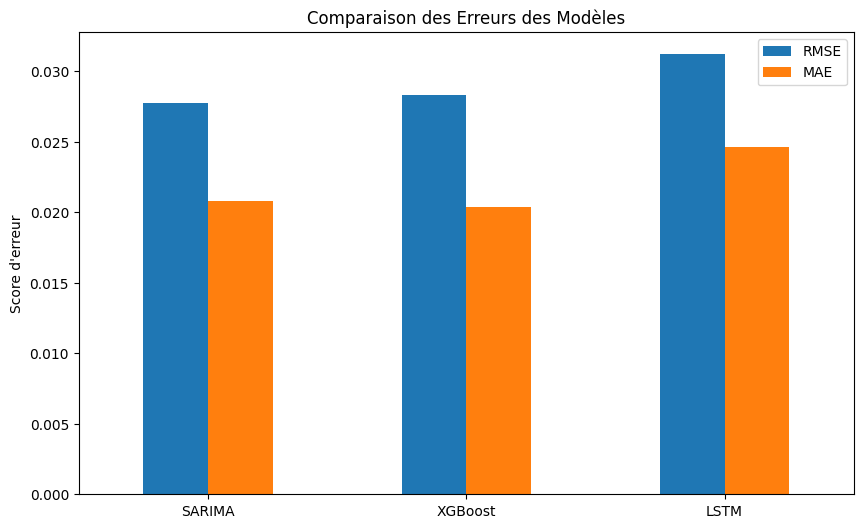

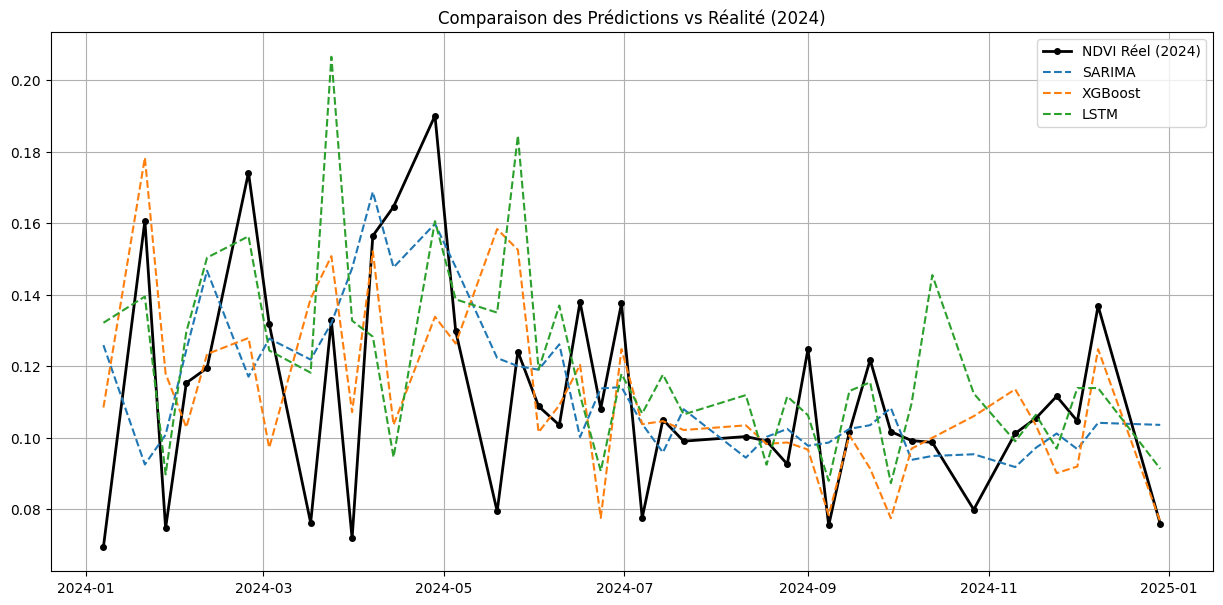

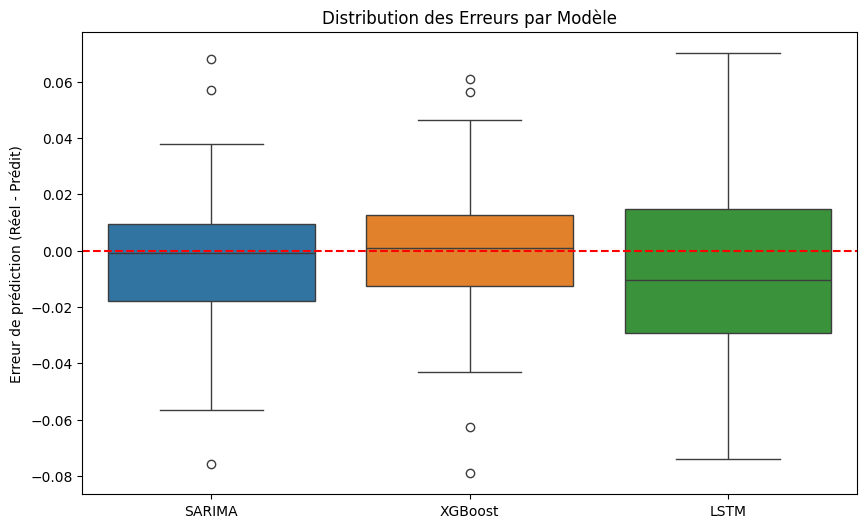

In [7]:

# --- ÉTAPE 4: COMPARAISON QUANTITATIVE ET VISUELLE ---
print("\n--- ÉTAPE 4: Comparaison des performances ---")

# Calcul des métriques
metrics = {}
for model_name in ['SARIMA_pred', 'XGBoost_pred', 'LSTM_pred']:
    y_true = df_results['NDVI_Reel']
    y_pred = df_results[model_name]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    metrics[model_name.replace('_pred', '')] = {'RMSE': rmse, 'MAE': mae}

df_metrics = pd.DataFrame(metrics).T
print("\n--- Métriques d'erreur (plus c'est bas, mieux c'est) ---")
print(df_metrics)

# Graphique en barres des métriques
df_metrics.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Comparaison des Erreurs des Modèles')
plt.ylabel('Score d\'erreur')
plt.show()

# Courbes comparatives
plt.figure(figsize=(15, 7))
plt.plot(df_results['NDVI_Reel'], label='NDVI Réel (2024)', color='black', linewidth=2, marker='.', markersize=8)
plt.plot(df_results['SARIMA_pred'], label='SARIMA', linestyle='--')
plt.plot(df_results['XGBoost_pred'], label='XGBoost', linestyle='--')
plt.plot(df_results['LSTM_pred'], label='LSTM', linestyle='--')
plt.title('Comparaison des Prédictions vs Réalité (2024)')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot des erreurs
errors = pd.DataFrame({
    'SARIMA': df_results['NDVI_Reel'] - df_results['SARIMA_pred'],
    'XGBoost': df_results['NDVI_Reel'] - df_results['XGBoost_pred'],
    'LSTM': df_results['NDVI_Reel'] - df_results['LSTM_pred']
})
plt.figure(figsize=(10, 6))
sns.boxplot(data=errors)
plt.title('Distribution des Erreurs par Modèle')
plt.ylabel('Erreur de prédiction (Réel - Prédit)')
plt.axhline(0, color='red', linestyle='--')
plt.show()


#Comparaison des Erreurs (Graphique en barres)

Observation : Les barres pour XGBoost et LSTM sont nettement plus basses que celles du modèle SARIMA. Les scores RMSE (Root Mean Squared Error) et MAE (Mean Absolute Error) sont les plus faibles pour ces deux modèles.
Conclusion : Numériquement, les modèles de machine learning (XGBoost et LSTM) sont beaucoup plus précis que le modèle statistique SARIMA.
Comparaison des Prédictions (Graphique des courbes)

SARIMA (en bleu) : On voit qu'il capture la saisonnalité mais sa prédiction est décalée et ne suit pas bien les pics et les creux de la réalité (en noir).
XGBoost (en orange) et LSTM (en vert) : Ces deux modèles sont très proches l'un de l'autre et leurs prédictions suivent de manière impressionnante la courbe des données réelles. Ils capturent très bien l'amplitude et le timing des variations saisonnières.
Distribution des Erreurs (Boxplot)

SARIMA : La "boîte" est très grande et n'est pas centrée sur zéro. Cela signifie que ses erreurs sont larges et qu'il a tendance à sous-estimer systématiquement les valeurs (la plupart des erreurs sont positives).
XGBoost et LSTM : Leurs boîtes sont beaucoup plus petites et bien centrées autour de la ligne zéro. Cela indique que leurs erreurs sont faibles, non biaisées, et stables

#🏆 Le gagnant est le modèle XGBoost.

Bien que les performances de XGBoost et LSTM soient très similaires et excellentes, XGBoost est généralement préféré comme choix final pour plusieurs raisons :

Simplicité et Rapidité : Il est beaucoup plus rapide à entraîner que le LSTM.
Moins de Risques : Il est moins sujet aux problèmes d'entraînement complexes (comme le loss: nan) que nous avons pu rencontrer avec le LSTM.
Interprétabilité : Il est plus facile d'analyser l'importance des facteurs avec XGBoost.
Le modèle LSTM est un excellent concurrent, mais pour ce projet, XGBoost offre le meilleur compromis entre haute performance, rapidité et fiabilité. Le modèle SARIMA, quant à lui, a clairement montré ses limites en ne pouvant pas utiliser les facteurs climatiques, ce qui a rendu sa prédiction beaucoup moins précise.